In [69]:
# import numerical functions, plotting functions and statistical functions
import numpy as np
# !pip install pip
# !pip install --upgrade pip
# !pip install scipy
import scipy as sp
import scipy.stats
import pandas as pd

# !pip install pystan
import stan
# !pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

# !pip install arviz
import arviz

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

TypeError: 'type' object is not subscriptable

In [70]:
pip freeze | grep arviz

arviz==0.16.1
Note: you may need to restart the kernel to use updated packages.


In [29]:
def diagnose(name):
    if 'disease' in name:
        return 1
    else:
        return 0

In [50]:
df = pd.read_csv('./data/kidney_countdata.txt', sep='\t', quotechar='"')
df.rename(columns={'Unnamed: 0': 'gene'}, inplace=True)

meta_df = pd.read_csv('./data/kidney_metadata.txt', sep='\t', quotechar='"')
meta_df.rename(columns={'Unnamed: 0': 'ROI'}, inplace=True)
meta_df['diagnosis'] = meta_df['slide name'].map(diagnose)

In [55]:
df = df.head(100)
threshold = 10
column_list = [col for col in df.columns if col != 'gene' and sum(df[col]) >= 10]
print(len(column_list))

269


In [19]:
print(sum(df['DSP-1001250007851-H-A02.dcc']))
print(max(df['DSP-1001250007851-H-A02.dcc']))
print(min(df[df['DSP-1001250007851-H-A02.dcc']>0]['DSP-1001250007851-H-A02.dcc']))
print(1 / 519757)
print(len(df.columns))

3583
485
13
1.923976011867084e-06
277


We develop a multinomial model where the health status (Normal or Diseased) associated with a sample $m$ is the dependent variable $Y_m\in\{0,1\}$ and the independent variable $X^m$ is the gene expression of the sample. We will model a score $Z=\beta\cdot X$, which can be converted into a probability of $Y_m$ given $(X^m,\beta)$. In our initial implementation, we model the $\beta$ values as being drawn from a normal distribution. Our model is therefore:
$$Y\in\{0, 1\}$$
$$Y^i\sim\text{Bernoulli}\left(\rho_i\right)$$
$$Z_i=\sum_j x_j^iB_j$$
$$P\left(Y_i\right)=\text{logit}\left(Z_i\right)$$
$$B_j\sim N\left(0,\sigma\right)$$
$$\sigma=1$$

In [36]:
# Note: below is based on Week 9 colab: https://colab.research.google.com/drive/1itBoJq9kUBVrEAkWWnsWtMB9RSrx1tt4?usp=sharing#scrollTo=abZBuL6lH-BL
model_code = """
data {
    int N;         // number of samples
    int q;         // number of predictors
    real X[N, q];  // predictors
    int<lower=0,upper=1> Y[N];     // response
    }
parameters {
    real alpha;
    vector[q] beta;
}
transformed parameters {
    real z[N];
    for (i in 1:N) {
        z[i] = alpha;
        for (j in 1:q)
        {
            z[i] += beta[j] * X[i, j];   // add the effect of every predictor on the mean
        }
    }
}
model {
    alpha ~ normal(0, 1);
    beta ~ normal(0, 1);
    for (i in 1:N) {
        Y[i] ~ bernoulli_logit(z[i]);
    }
}
"""

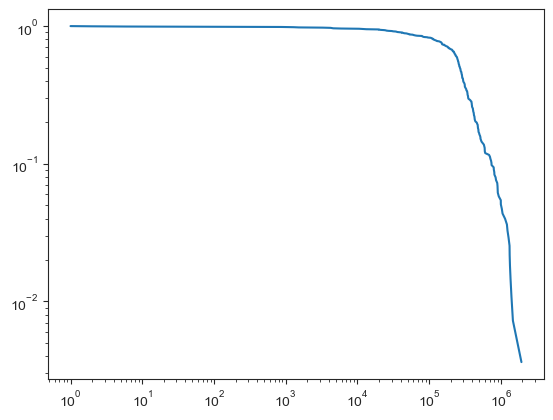

(array([15., 12., 10.,  5.,  7.,  7.,  6., 12.,  6.,  7.,  7., 11., 15.,
        21., 20., 10., 10., 11.,  4.,  2.,  9.,  8.,  6.,  1.,  5.,  5.,
         3.,  2.,  1.,  1.,  4.,  1.,  0.,  0.,  0.,  1.,  2.,  1.,  2.,
         0.,  0.,  3.,  1.,  1.,  1.,  1.,  3.,  0.,  1.,  0.,  0.,  2.,
         0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,
         0.,  1.,  0.,  2.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([1.00000000e+00, 1.93513900e+04, 3.87017800e+04, 5.80521700e+04,
        7.74025600e+04, 9.67529500e+04, 1.16103340e+05, 1.35453730e+05,
        1.54804120e+05, 1.74154510e+05, 1.93504900e+05, 2.12855290e+05,
        2.32205680e+05, 2.51556070e+05, 2.70906460e+05, 2.90256850e+05,
        3.09607240e+05, 3.28957630e+05, 3.48308020e+05, 3.67658410e+05,
        3.87008800e+05, 4.06359190e+05, 4.25709580e+05, 4.45059970e+05,
  

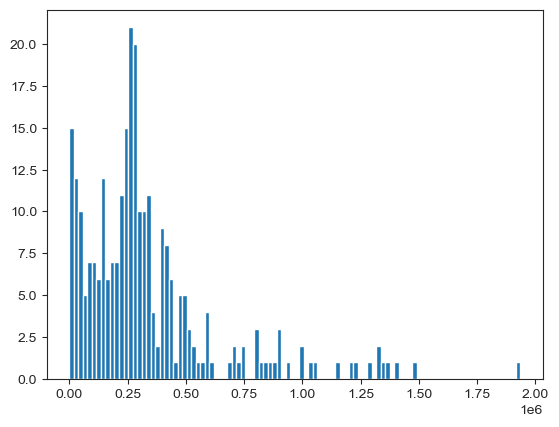

In [52]:
counts = [sum(df[col]) for col in df.columns[1:]]
counts.sort()
ccdf = 1.0 - np.arange(len(counts)) / len(counts)
plt.plot(counts, ccdf)
plt.xscale('log')
plt.yscale('log')
plt.show()
plt.hist(counts, bins=100)
# for col in df.columns[1:]:
#     if sum(df[col]) < 10:
#         print(col)
#         print(sum(df[col]))

In [58]:
# Currently normalizing by sum of all counts for an ROI, multiplied by 1,000 to prevent underflow
X = np.array([df[col]*10/sum(df[col]) for col in column_list])
print(len(X))

Y = []
for col in column_list:
    Y.append(meta_df[meta_df['ROI']==col]['diagnosis'].values[0])

print(len(Y))

269
269


In [59]:
model = stan.build(model_code, data={'N': len(X), 'q': len(df), 'X': X, 'Y': Y})

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/httpstan_b6bhz2yn/model_ducafblz.stan', line 5, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/httpstan_b6bhz2yn/model_ducafblz.stan', line 6, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/kz/zvrl2np1735fmnw3g0klx3c40000gn/T/httpstan_b6bhz2yn/model_ducafblz.stan', line 13, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will 

In [60]:
fit = model.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Samplin

In [61]:
fit_multiple_az = az.from_pystan(fit_multiple)
az.summary(fit_multiple_az)

NameError: name 'az' is not defined